In [1]:
import vtk
import numpy as np
import torch
from torch_geometric.data import Data
from pathlib import Path
import glob
import re
import json
from datetime import datetime
import pickle
from collections import defaultdict
from sklearn.model_selection import train_test_split

class KarmanVortexProcessor:
    """
    Clean processor for Karman vortex street simulations.
    Converts VTK data to PyTorch Geometric format with Reynolds number as global parameter.
    Uses ONLY raw data from VTK files - no derived features.
    """
    
    def __init__(self, base_data_dir, include_parameters_as_features=True):
        self.base_data_dir = Path(base_data_dir)
        self.include_parameters_as_features = include_parameters_as_features
        
        # Physical variable names from VTK files - RAW DATA ONLY
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        
        # Global parameters
        self.parameter_names = ['reynolds_number']
        
        # For tracking processed cases
        self.case_info = {}
        self.all_variable_stats = {}
        self.parameter_stats = {}
        
    def discover_reynolds_cases(self):
        """Discover all available Reynolds number cases."""
        print(f"Discovering Karman vortex cases in: {self.base_data_dir}")
        
        if not self.base_data_dir.exists():
            print(f"Directory {self.base_data_dir} does not exist!")
            return []
        
        case_dirs = []
        reynolds_dirs = sorted([d for d in self.base_data_dir.iterdir() 
                               if d.is_dir() and 'Reynolds' in d.name])
        
        print(f"Found {len(reynolds_dirs)} Reynolds directories")
        
        for re_dir in reynolds_dirs:
            # Extract Reynolds number from directory name
            re_match = re.search(r'Reynolds[_\s]*(\d+)', re_dir.name)
            if re_match:
                reynolds_num = int(re_match.group(1))
                vtk_dir = re_dir / "VTK"
                
                if vtk_dir.exists():
                    # Look for timestep directories
                    timestep_dirs = [d for d in vtk_dir.iterdir() if d.is_dir()]
                    
                    if timestep_dirs:
                        # Check for internal.vtu files in timestep directories
                        valid_timesteps = []
                        for ts_dir in timestep_dirs:
                            internal_file = ts_dir / "internal.vtu"
                            if internal_file.exists():
                                # Extract timestep number from directory name
                                ts_match = re.search(r'(\d+)', ts_dir.name)
                                if ts_match:
                                    timestep = int(ts_match.group(1))
                                    valid_timesteps.append((timestep, ts_dir))
                        
                        if valid_timesteps:
                            valid_timesteps.sort()  # Sort by timestep
                            case_name = f"Reynolds_{reynolds_num}"
                            case_dirs.append((vtk_dir, case_name, reynolds_num, valid_timesteps))
                            print(f"  {case_name}: {len(valid_timesteps)} timesteps")
                        else:
                            print(f"  {re_dir.name}: No valid internal.vtu files found")
                    else:
                        print(f"  {re_dir.name}: No timestep directories in VTK")
                else:
                    print(f"  {re_dir.name}: No VTK directory found")
            else:
                print(f"  {re_dir.name}: Could not extract Reynolds number")
        
        if not case_dirs:
            print("No valid Reynolds cases found!")
        else:
            print(f"Total valid Reynolds cases: {len(case_dirs)}")
            
        return case_dirs
    
    def read_vtu_data(self, filename):
        """Read VTU file and extract mesh data and fields."""
        reader = vtk.vtkXMLUnstructuredGridReader()
        reader.SetFileName(str(filename))
        reader.Update()
        mesh = reader.GetOutput()
        
        # Extract positions
        points = mesh.GetPoints()
        pos = np.array([points.GetPoint(i) for i in range(points.GetNumberOfPoints())])
        
        # Extract point data (physics fields)
        point_data = mesh.GetPointData()
        fields = {}
        
        for i in range(point_data.GetNumberOfArrays()):
            array = point_data.GetArray(i)
            name = array.GetName()
            n_components = array.GetNumberOfComponents()
            
            if name == 'p':  # Pressure field
                data = np.array([array.GetValue(j) for j in range(array.GetNumberOfTuples())])
                fields['pressure'] = data
            elif name == 'U':  # Velocity vector field
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                fields['velocity_x'] = data[:, 0]
                fields['velocity_y'] = data[:, 1] 
                fields['velocity_z'] = data[:, 2]
            elif name == 'vorticity':  # Vorticity vector field
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                fields['vorticity_x'] = data[:, 0]
                fields['vorticity_y'] = data[:, 1]
                fields['vorticity_z'] = data[:, 2]
            elif n_components == 1:
                # Generic scalar field
                data = np.array([array.GetValue(j) for j in range(array.GetNumberOfTuples())])
                fields[name] = data
            else:
                # Generic vector field
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                for comp in range(n_components):
                    fields[f"{name}_{comp}"] = data[:, comp]
        
        return pos, fields, mesh
    
    def extract_mesh_connectivity(self, mesh):
        """Extract mesh connectivity for graph structure."""
        edge_set = set()
        n_cells = mesh.GetNumberOfCells()
        
        for i in range(n_cells):
            cell = mesh.GetCell(i)
            cell_type = cell.GetCellType()
            n_points = cell.GetNumberOfPoints()
            
            point_ids = [cell.GetPointId(j) for j in range(n_points)]
            edges = self._get_cell_edges(cell_type, point_ids)
            
            for edge in edges:
                edge_set.add(tuple(sorted(edge)))
        
        # Convert to directed edges
        directed_edges = []
        for edge in edge_set:
            directed_edges.append([edge[0], edge[1]])
            directed_edges.append([edge[1], edge[0]])
        
        return np.array(directed_edges).T if directed_edges else np.array([[], []])
    
    def _get_cell_edges(self, cell_type, point_ids):
        """Get edges for different VTK cell types."""
        edges = []
        
        if cell_type == 12:  # Hexahedron
            edges = [
                # Bottom face
                [point_ids[0], point_ids[1]], [point_ids[1], point_ids[2]], 
                [point_ids[2], point_ids[3]], [point_ids[3], point_ids[0]],
                # Top face  
                [point_ids[4], point_ids[5]], [point_ids[5], point_ids[6]], 
                [point_ids[6], point_ids[7]], [point_ids[7], point_ids[4]],
                # Vertical edges
                [point_ids[0], point_ids[4]], [point_ids[1], point_ids[5]], 
                [point_ids[2], point_ids[6]], [point_ids[3], point_ids[7]]
            ]
        elif cell_type == 13:  # Wedge
            edges = [
                [point_ids[0], point_ids[1]], [point_ids[1], point_ids[2]], [point_ids[2], point_ids[0]],
                [point_ids[3], point_ids[4]], [point_ids[4], point_ids[5]], [point_ids[5], point_ids[3]],
                [point_ids[0], point_ids[3]], [point_ids[1], point_ids[4]], [point_ids[2], point_ids[5]]
            ]
        else:  # Other types - connect all pairs (simplified)
            for i in range(len(point_ids)):
                for j in range(i + 1, len(point_ids)):
                    edges.append([point_ids[i], point_ids[j]])
        
        return edges
    
    def create_global_parameters(self, reynolds_number):
        """Create global parameter tensor for the graph."""
        if not self.include_parameters_as_features:
            return None
        
        global_params = torch.tensor([float(reynolds_number)], dtype=torch.float)
        return global_params
    
    def analyze_variable_ranges_single_case(self, case_dir, case_name, reynolds_number, timesteps):
        """Analyze variable ranges for a single Reynolds case."""
        print(f"  Analyzing variable ranges for {case_name}...")
        
        case_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                           'all_values': []} for var in self.physics_vars}
        
        valid_files_count = 0
        
        for timestep, ts_dir in timesteps[:10]:  # Sample first 10 timesteps for efficiency
            internal_file = ts_dir / "internal.vtu"
            try:
                pos, fields, mesh = self.read_vtu_data(internal_file)
                
                valid_files_count += 1
                
                for var in self.physics_vars:
                    if var in fields:
                        data = fields[var]
                        # Filter out invalid values
                        valid_data = data[np.isfinite(data)]
                        if len(valid_data) > 0:
                            case_stats[var]['min'] = min(case_stats[var]['min'], valid_data.min())
                            case_stats[var]['max'] = max(case_stats[var]['max'], valid_data.max())
                            case_stats[var]['all_values'].extend(valid_data.flatten())
                
            except Exception as e:
                continue  # Skip problematic files silently
        
        if valid_files_count == 0:
            print(f"    Warning: No valid files could be read for case {case_name}")
            return None
        
        # Compute additional statistics
        final_stats = {}
        for var in self.physics_vars:
            if case_stats[var]['all_values'] and case_stats[var]['min'] != float('inf'):
                values = np.array(case_stats[var]['all_values'])
                final_stats[var] = {
                    'min': float(case_stats[var]['min']),
                    'max': float(case_stats[var]['max']),
                    'mean': float(values.mean()),
                    'std': float(values.std()),
                    'median': float(np.median(values)),
                    'q25': float(np.percentile(values, 25)),
                    'q75': float(np.percentile(values, 75))
                }
        
        return final_stats if final_stats else None
    
    def process_single_case(self, case_dir, case_name, reynolds_number, timesteps, output_path):
        """Process a single Reynolds case into PyG format."""
        print(f"Processing case: {case_name}")
        print(f"  Reynolds number: {reynolds_number}")
        print(f"  Timesteps: {len(timesteps)}")
        
        if len(timesteps) < 2:
            print(f"  Case {case_name} has insufficient timesteps ({len(timesteps)}). Skipping.")
            return None
        
        # Store parameter statistics
        self.parameter_stats[case_name] = {
            'reynolds_number': reynolds_number
        }
        
        # Analyze variable ranges for this case
        case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name, reynolds_number, timesteps)
        
        pyg_data_list = []
        
        # Read first timestep to get mesh structure (static across timesteps)
        first_timestep, first_ts_dir = timesteps[0]
        first_internal = first_ts_dir / "internal.vtu"
        pos, _, mesh = self.read_vtu_data(first_internal)
        
        # Extract connectivity (static)
        edge_index = self.extract_mesh_connectivity(mesh)
        edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
        
        # Create position tensor (static features)
        pos_tensor = torch.tensor(pos, dtype=torch.float)
        
        # Create global parameter features
        global_params = self.create_global_parameters(reynolds_number)
        
        # Process consecutive timestep pairs
        valid_pairs = 0
        total_pairs = len(timesteps) - 1
        
        for i in range(total_pairs):
            if i % 50 == 0:
                print(f"    Processing timestep pairs: {i}/{total_pairs}")
                
            current_timestep, current_ts_dir = timesteps[i]
            next_timestep, next_ts_dir = timesteps[i + 1]
            
            try:
                # Read current and next timestep data
                current_file = current_ts_dir / "internal.vtu"
                next_file = next_ts_dir / "internal.vtu"
                
                _, current_fields, _ = self.read_vtu_data(current_file)
                _, next_fields, _ = self.read_vtu_data(next_file)
                
                # Create feature arrays for available variables (RAW DATA ONLY)
                available_vars = [var for var in self.physics_vars if var in current_fields]
                
                current_features = np.stack([current_fields[var] for var in available_vars], axis=-1)
                next_features = np.stack([next_fields[var] for var in available_vars], axis=-1)
                
                # Create PyG tensors
                x = torch.tensor(current_features, dtype=torch.float)  # [N, num_physics_vars]
                y = torch.tensor(next_features, dtype=torch.float)     # [N, num_physics_vars]
                
                # Create PyG Data object
                data_object = Data(
                    x=x,                              # Dynamic physics features  
                    pos=pos_tensor,                   # Static position features
                    edge_index=edge_index_tensor,     # Static connectivity
                    y=y,                             # Target (next timestep)
                    
                    # Global parameters
                    global_params=global_params if self.include_parameters_as_features else None,
                    
                    # Metadata
                    case_name=case_name,
                    reynolds_number=reynolds_number,
                    timestep_current=current_timestep,
                    timestep_next=next_timestep,
                    feature_names=available_vars
                )
                
                pyg_data_list.append(data_object)
                valid_pairs += 1
                
            except Exception as e:
                continue  # Skip problematic timestep pairs silently
        
        print(f"  Successfully processed {valid_pairs} timestep pairs")
        
        if pyg_data_list:
            # Save this case separately
            case_filename = f"{case_name}_raw_data.pt"
            case_filepath = output_path / "individual_cases" / case_filename
            case_filepath.parent.mkdir(exist_ok=True)
            torch.save(pyg_data_list, case_filepath)
            print(f"  Saved individual case: {case_filepath}")
        
        # Store case information
        self.case_info[case_name] = {
            'total_timesteps': len(timesteps),
            'processed_pairs': len(pyg_data_list),
            'directory': str(case_dir),
            'reynolds_number': reynolds_number,
            'variable_statistics': case_var_stats,
            'feature_dimensions': {
                'node_features': len(available_vars) if pyg_data_list else 0,
                'position_features': 3,  # x, y, z coordinates
                'global_features': 1 if self.include_parameters_as_features else 0,  # Reynolds number
            },
            'saved_file': str(case_filepath) if pyg_data_list else None
        }
        
        return pyg_data_list
    
    def analyze_global_variable_ranges(self, case_info_list):
        """Analyze variable ranges across all Reynolds cases."""
        print("Analyzing variable ranges across all Reynolds cases")
        
        global_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                             'case_mins': [], 'case_maxs': [], 'case_means': []} 
                       for var in self.physics_vars}
        
        case_stats_summary = {}
        processed_cases = 0
        
        for case_dir, case_name, reynolds_number, timesteps in case_info_list:
            case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name, reynolds_number, timesteps)
            
            if case_var_stats is not None and case_var_stats:
                case_stats_summary[case_name] = case_var_stats
                processed_cases += 1
                
                for var in self.physics_vars:
                    if var in case_var_stats and 'mean' in case_var_stats[var]:
                        stats = case_var_stats[var]
                        global_stats[var]['min'] = min(global_stats[var]['min'], stats['min'])
                        global_stats[var]['max'] = max(global_stats[var]['max'], stats['max'])
                        global_stats[var]['case_mins'].append(stats['min'])
                        global_stats[var]['case_maxs'].append(stats['max'])
                        global_stats[var]['case_means'].append(stats['mean'])
        
        # Compute global statistics
        for var in self.physics_vars:
            if global_stats[var]['case_means']:
                global_stats[var]['global_mean_of_means'] = np.mean(global_stats[var]['case_means'])
                global_stats[var]['std_of_means'] = np.std(global_stats[var]['case_means'])
                global_stats[var]['range'] = global_stats[var]['max'] - global_stats[var]['min']
        
        print(f"Global variable statistics summary (from {processed_cases} cases):")
        for var in self.physics_vars:
            stats = global_stats[var]
            if stats['case_means']:
                print(f"  {var.upper()}:")
                print(f"    Global Range: [{stats['min']:.6e}, {stats['max']:.6e}]")
                print(f"    Range Span: {stats['range']:.6e}")
                print(f"    Mean across cases: {stats['global_mean_of_means']:.6e} ± {stats['std_of_means']:.6e}")
        
        self.all_variable_stats = {
            'global_statistics': global_stats,
            'case_statistics': case_stats_summary
        }
        
        return global_stats, case_stats_summary
    
    def process_all_cases(self, output_dir="processed_karman_datasets"):
        """Process all discovered Reynolds cases."""
        print("BATCH PROCESSING ALL KARMAN VORTEX CASES - RAW DATA ONLY")
        
        case_info_list = self.discover_reynolds_cases()
        if not case_info_list:
            print("No cases found to process!")
            return None
        
        # First, analyze variable ranges across all cases
        global_stats, case_stats = self.analyze_global_variable_ranges(case_info_list)
        
        if global_stats is None:
            print("Variable range analysis failed!")
            return None
        
        # Create output directory
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        (output_path / "individual_cases").mkdir(exist_ok=True)
        
        all_data = []
        case_sample_counts = {}
        reynolds_numbers = []
        
        print("Processing individual Reynolds cases:")
        
        # Process each case
        for case_dir, case_name, reynolds_number, timesteps in case_info_list:
            case_data = self.process_single_case(case_dir, case_name, reynolds_number, timesteps, output_path)
            
            if case_data:
                all_data.extend(case_data)
                case_sample_counts[case_name] = len(case_data)
                reynolds_numbers.append(reynolds_number)
            else:
                print(f"  No data processed for case: {case_name}")
        
        if not all_data:
            print("No data was successfully processed!")
            return None
        
        # Calculate Reynolds number statistics
        reynolds_stats = {
            'min': min(reynolds_numbers),
            'max': max(reynolds_numbers),
            'unique_values': sorted(list(set(reynolds_numbers)))
        }
        
        print("Processing summary:")
        print(f"  Total Reynolds cases processed: {len(case_sample_counts)}")
        print(f"  Total samples: {len(all_data)}")
        print(f"  Reynolds numbers: {reynolds_stats['unique_values']}")
        print(f"  Node feature dimensions: {all_data[0].x.shape[1]} per node")
        print(f"  Position feature dimensions: {all_data[0].pos.shape[1]}")
        
        if self.include_parameters_as_features:
            print(f"  Global parameter dimensions: {all_data[0].global_params.shape[0] if all_data[0].global_params is not None else 0}")
            print(f"    - Position features: 3D coordinates")
            print(f"    - Dynamic features: RAW physics fields only")
            print(f"    - Global features: Reynolds number")
        
        # Save comprehensive metadata
        metadata = {
            'timestamp': datetime.now().isoformat(),
            'data_processing': 'RAW_DATA_ONLY - No derived features',
            'total_samples': len(all_data),
            'total_cases': len(case_sample_counts),
            'include_parameters_as_features': self.include_parameters_as_features,
            'parameter_storage_method': 'global_graph_attributes' if self.include_parameters_as_features else None,
            'parameter_names': self.parameter_names if self.include_parameters_as_features else [],
            'case_info': self.case_info,
            'case_sample_counts': case_sample_counts,
            'parameter_statistics': self.parameter_stats,
            'variable_statistics': self.all_variable_stats,
            'reynolds_summary': reynolds_stats,
            'feature_layout': self._get_feature_layout_description(),
            'target_layout': 'same as features (next timestep)',
            'physics_model': 'Incompressible Navier-Stokes with Karman vortex shedding',
            'domain_description': 'Flow around cylinder',
            'mesh_type': 'Unstructured VTK mesh'
        }
        
        with open(output_path / 'karman_dataset_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save variable statistics separately
        with open(output_path / 'variable_statistics.json', 'w') as f:
            json.dump(self.all_variable_stats, f, indent=2)
        
        return all_data, output_path
    
    def create_train_test_val_split(self, all_data, output_path, 
                                  train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                  random_state=42, split_by_reynolds=True):
        """Create train/test/validation splits by Reynolds numbers for extrapolation testing."""
        print("Creating train/test/val split")
        print(f"  Ratios - Train: {train_ratio}, Val: {val_ratio}, Test: {test_ratio}")
        
        if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
            print("Split ratios don't sum to 1.0!")
            return None
        
        # Group data by Reynolds number
        reynolds_groups = {}
        for data in all_data:
            re_num = data.reynolds_number
            if re_num not in reynolds_groups:
                reynolds_groups[re_num] = []
            reynolds_groups[re_num].append(data)
        
        print(f"  Found {len(reynolds_groups)} unique Reynolds numbers")
        reynolds_list = sorted(reynolds_groups.keys())
        print(f"  Reynolds numbers: {reynolds_list}")
        
        if split_by_reynolds:
            # Split by Reynolds number for physics extrapolation testing
            n_reynolds = len(reynolds_list)
            train_end = int(n_reynolds * train_ratio)
            val_end = train_end + int(n_reynolds * val_ratio)
            
            train_reynolds = reynolds_list[:train_end]
            val_reynolds = reynolds_list[train_end:val_end]
            test_reynolds = reynolds_list[val_end:]
            
            print(f"  Reynolds split assignment:")
            print(f"    Train: {train_reynolds}")
            print(f"    Val:   {val_reynolds}")
            print(f"    Test:  {test_reynolds}")
            
            # Assign ALL samples from each Reynolds to designated split
            train_data = []
            val_data = []
            test_data = []
            
            for re_num in train_reynolds:
                train_data.extend(reynolds_groups[re_num])
            for re_num in val_reynolds:
                val_data.extend(reynolds_groups[re_num])
            for re_num in test_reynolds:
                test_data.extend(reynolds_groups[re_num])
        else:
            # Random split by individual samples
            train_data, temp_data = train_test_split(all_data, test_size=(1-train_ratio), random_state=random_state)
            val_data, test_data = train_test_split(temp_data, test_size=(test_ratio/(val_ratio+test_ratio)), random_state=random_state)
        
        print(f"Final split sizes:")
        print(f"  Train: {len(train_data)} samples ({len(train_data)/len(all_data)*100:.1f}%)")
        print(f"  Val:   {len(val_data)} samples ({len(val_data)/len(all_data)*100:.1f}%)")
        print(f"  Test:  {len(test_data)} samples ({len(test_data)/len(all_data)*100:.1f}%)")
        
        # Save the datasets
        datasets = {
            'train': train_data,
            'val': val_data,
            'test': test_data
        }
        
        saved_files = {}
        for split_name, split_data in datasets.items():
            filename = f"karman_vortex_{split_name}_raw.pt"
            filepath = output_path / filename
            torch.save(split_data, filepath)
            saved_files[split_name] = str(filepath)
            print(f"  Saved {split_name} split: {filepath}")
        
        # Update metadata with split information
        split_metadata = {
            'split_method': 'reynolds_numbers' if split_by_reynolds else 'random_samples',
            'split_ratios': {'train': train_ratio, 'val': val_ratio, 'test': test_ratio},
            'split_sizes': {
                'train': len(train_data), 
                'val': len(val_data), 
                'test': len(test_data)
            },
            'reynolds_assignment': {
                'train_reynolds': train_reynolds if split_by_reynolds else 'mixed',
                'val_reynolds': val_reynolds if split_by_reynolds else 'mixed',
                'test_reynolds': test_reynolds if split_by_reynolds else 'mixed'
            },
            'random_state': random_state,
            'saved_files': saved_files
        }
        
        # Load existing metadata and add split info
        metadata_file = output_path / 'karman_dataset_metadata.json'
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        metadata['train_test_val_split'] = split_metadata
        
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"Updated metadata: {metadata_file}")
        
        return datasets
    
    def _get_feature_layout_description(self):
        """Get description of the feature layout."""
        if self.include_parameters_as_features:
            return {
                'position_features': '[x_pos, y_pos, z_pos] (static)',
                'node_features': '[pressure, velocity_x, velocity_y, velocity_z, vorticity_x, vorticity_y, vorticity_z] (dynamic, RAW DATA ONLY)',
                'global_features': '[reynolds_number]'
            }
        else:
            return {
                'position_features': '[x_pos, y_pos, z_pos] (static)',
                'node_features': '[pressure, velocity_x, velocity_y, velocity_z, vorticity_x, vorticity_y, vorticity_z] (dynamic, RAW DATA ONLY)',
                'global_features': 'none'
            }


class KarmanDatasetNormalizer:
    """
    Normalizer for Karman vortex street datasets.
    """
    
    def __init__(self, source_dir, target_dir, metadata_file="karman_dataset_metadata.json"):
        self.source_dir = Path(source_dir)
        self.target_dir = Path(target_dir)
        self.target_dir.mkdir(exist_ok=True)
        
        # Variable names - RAW DATA ONLY
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        self.position_vars = ['x_pos', 'y_pos', 'z_pos']
        
        # Load metadata
        metadata_path = self.source_dir / metadata_file
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Extract normalization parameters
        self.normalization_params = self._compute_normalization_params()
        self.global_param_normalization = self._compute_global_param_normalization()
        
    def _compute_normalization_params(self):
        """Compute global min/max for each variable from metadata."""
        print("Computing global normalization parameters...")
        
        params = {}
        global_stats = self.metadata['variable_statistics']['global_statistics']
        
        for var in self.physics_vars:
            if var in global_stats:
                var_min = global_stats[var]['min']
                var_max = global_stats[var]['max']
                params[var] = {'min': var_min, 'max': var_max}
                print(f"  {var}: [{var_min:.6e}, {var_max:.6e}]")
            else:
                print(f"  Warning: {var} not found in global statistics")
        
        return params
    
    def _compute_global_param_normalization(self):
        """Compute normalization for global parameters (Reynolds number)."""
        print("Computing global parameter normalization...")
        
        if 'reynolds_summary' in self.metadata:
            reynolds_stats = self.metadata['reynolds_summary']
            return {
                'reynolds_number': {
                    'min': float(reynolds_stats['min']),
                    'max': float(reynolds_stats['max'])
                }
            }
        return {}
    
    def normalize_tensor(self, data, var_name, param_dict=None):
        """Normalize a tensor using min-max normalization."""
        if param_dict is None:
            param_dict = self.normalization_params
        
        if var_name not in param_dict:
            print(f"Warning: {var_name} not found in normalization parameters")
            return data.clone()
        
        params = param_dict[var_name]
        var_min, var_max = params['min'], params['max']
        
        if var_max == var_min:
            return torch.zeros_like(data)
        
        normalized = (data - var_min) / (var_max - var_min)
        normalized = torch.clamp(normalized, 0.0, 1.0)
        
        return normalized
    
    def normalize_global_params(self, global_params):
        """Normalize global parameters (Reynolds number)."""
        if global_params is None or len(self.global_param_normalization) == 0:
            return global_params.clone() if global_params is not None else None
        
        normalized_params = global_params.clone()
        
        if 'reynolds_number' in self.global_param_normalization:
            normalized_params[0] = self.normalize_tensor(
                global_params[0], 'reynolds_number', self.global_param_normalization
            )
        
        return normalized_params
    
    def normalize_position(self, pos):
        """Normalize position coordinates to [0,1] based on domain bounds."""
        # Extract domain bounds from positions themselves
        pos_min = pos.min(dim=0)[0]
        pos_max = pos.max(dim=0)[0]
        
        # Normalize to [0,1]
        pos_range = pos_max - pos_min
        pos_range = torch.where(pos_range == 0, torch.ones_like(pos_range), pos_range)
        
        normalized_pos = (pos - pos_min) / pos_range
        return torch.clamp(normalized_pos, 0.0, 1.0)
    
    def normalize_sample(self, data):
        """Normalize a single PyG Data object."""
        # Normalize dynamic features (x)
        x_normalized = data.x.clone()
        available_features = data.feature_names if hasattr(data, 'feature_names') else self.physics_vars[:data.x.shape[1]]
        
        for i, var_name in enumerate(available_features):
            if i < data.x.shape[1]:
                x_normalized[:, i] = self.normalize_tensor(data.x[:, i], var_name)
        
        # Normalize targets (y) - same variables as features
        y_normalized = data.y.clone()
        for i, var_name in enumerate(available_features):
            if i < data.y.shape[1]:
                y_normalized[:, i] = self.normalize_tensor(data.y[:, i], var_name)
        
        # Normalize position (static features)
        pos_normalized = self.normalize_position(data.pos)
        
        # Create normalized data object
        normalized_data = data.clone()
        normalized_data.x = x_normalized
        normalized_data.y = y_normalized
        normalized_data.pos = pos_normalized
        
        # Normalize global parameters
        if hasattr(data, 'global_params') and data.global_params is not None:
            normalized_data.global_params = self.normalize_global_params(data.global_params)
        
        return normalized_data
    
    def normalize_dataset_file(self, input_file, output_file):
        """Normalize a single dataset file."""
        print(f"  Loading: {input_file}")
        dataset = torch.load(input_file, weights_only=False)
        
        print(f"  Normalizing {len(dataset)} samples...")
        normalized_dataset = []
        
        for i, data in enumerate(dataset):
            if i % 100 == 0:
                print(f"    Progress: {i}/{len(dataset)}")
            
            normalized_data = self.normalize_sample(data)
            normalized_dataset.append(normalized_data)
        
        print(f"  Saving: {output_file}")
        torch.save(normalized_dataset, output_file)
        
        return len(normalized_dataset)
    
    def normalize_all_datasets(self):
        """Normalize all dataset files."""
        print("NORMALIZING KARMAN VORTEX DATASETS")
        
        total_samples = 0
        
        # Normalize main split files
        splits = ['train', 'val', 'test']
        for split in splits:
            input_file = self.source_dir / f"karman_vortex_{split}_raw.pt"
            output_file = self.target_dir / f"karman_vortex_{split}_normalized.pt"
            
            if input_file.exists():
                samples = self.normalize_dataset_file(input_file, output_file)
                total_samples += samples
                print(f"  {split}: {samples} samples normalized")
            else:
                print(f"  {split}: File not found")
        
        # Normalize individual cases
        individual_cases_dir = self.source_dir / "individual_cases"
        if individual_cases_dir.exists():
            normalized_cases_dir = self.target_dir / "individual_cases_normalized"
            normalized_cases_dir.mkdir(exist_ok=True)
            
            case_files = list(individual_cases_dir.glob("*.pt"))
            print(f"Normalizing {len(case_files)} individual cases...")
            
            for case_file in case_files:
                output_file = normalized_cases_dir / f"{case_file.stem}_normalized.pt"
                samples = self.normalize_dataset_file(case_file, output_file)
                total_samples += samples
        
        # Save normalization metadata
        norm_metadata = {
            'normalization_method': 'min_max_0_to_1',
            'normalization_params': self.normalization_params,
            'global_param_normalization': self.global_param_normalization,
            'original_metadata': self.metadata
        }
        
        with open(self.target_dir / 'normalization_metadata.json', 'w') as f:
            json.dump(norm_metadata, f, indent=2)
        
        print(f"NORMALIZATION COMPLETE!")
        print(f"Total samples normalized: {total_samples}")
        
        return total_samples


def main():
    """Main execution function for Karman vortex street processing."""
    BASE_DATA_DIR = "/home/jtb3sud/Kármán vortex street"
    OUTPUT_DIR = "/project/vil_baek/psaap/cylinder"
    
    print("KARMAN VORTEX STREET DATASET PROCESSOR")
    print("Processing VTK cylinder flow data - RAW DATA ONLY")
    print(f"Source: {BASE_DATA_DIR}")
    print(f"Output: {OUTPUT_DIR}")
    
    # Initialize processor
    processor = KarmanVortexProcessor(BASE_DATA_DIR)
    
    # Process all cases
    result = processor.process_all_cases(output_dir=OUTPUT_DIR)
    
    if result is None:
        print("Processing failed!")
        return
    
    all_data, output_path = result
    
    print("READY FOR TRAIN/TEST/VAL SPLIT")
    print("Variable range analysis complete")
    print("Individual simulations saved")
    
    # Create train/test/val splits
    datasets = processor.create_train_test_val_split(
        all_data, 
        output_path,
        train_ratio=0.7,
        val_ratio=0.15, 
        test_ratio=0.15,
        split_by_reynolds=True  # Split by Reynolds for physics extrapolation testing
    )
    
    if datasets:
        print("NORMALIZING DATASETS")
        
        # Normalize datasets
        normalizer = KarmanDatasetNormalizer(output_path, output_path / "normalized")
        normalizer.normalize_all_datasets()
    
    print("KARMAN VORTEX PROCESSING COMPLETE!")
    print(f"All outputs saved to: {output_path}")
    print("Generated files:")
    print("  Analysis files:")
    print("    - karman_dataset_metadata.json")
    print("    - variable_statistics.json")
    print("  Individual simulations:")
    print("    - individual_cases/*.pt")
    print("  Train/Test/Val splits:")
    print("    - karman_vortex_train_raw.pt")
    print("    - karman_vortex_val_raw.pt")
    print("    - karman_vortex_test_raw.pt")
    print("  Normalized datasets:")
    print("    - normalized/karman_vortex_*_normalized.pt")
    print("    - normalized/individual_cases_normalized/*.pt")


if __name__ == "__main__":
    main()

/home/jtb3sud/.local/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/jtb3sud/.local/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /sfs/gpfs/tardis/home/jtb3sud/.local/lib/python3.11/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/jtb3sud/.local/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /sfs/gpfs/tardis/home/jtb3sud/.local/lib/python3.11/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _

KARMAN VORTEX STREET DATASET PROCESSOR
Processing VTK cylinder flow data - RAW DATA ONLY
Source: /home/jtb3sud/Kármán vortex street
Output: /project/vil_baek/psaap/cylinder
BATCH PROCESSING ALL KARMAN VORTEX CASES - RAW DATA ONLY
Discovering Karman vortex cases in: /home/jtb3sud/Kármán vortex street
Found 2 Reynolds directories
  Reynolds_100: 201 timesteps
  Reynolds_20: 201 timesteps
Total valid Reynolds cases: 2
Analyzing variable ranges across all Reynolds cases
  Analyzing variable ranges for Reynolds_100...
  Analyzing variable ranges for Reynolds_20...
Global variable statistics summary (from 2 cases):
  PRESSURE:
    Global Range: [-1.911050e-02, 1.359397e-02]
    Range Span: 3.270447e-02
    Mean across cases: -3.787437e-04 ± 3.326404e-04
  VELOCITY_X:
    Global Range: [-4.026441e-02, 2.127361e-01]
    Range Span: 2.530005e-01
    Mean across cases: 7.865621e-02 ± 5.240409e-02
  VELOCITY_Y:
    Global Range: [-1.034860e-01, 1.134597e-01]
    Range Span: 2.169457e-01
    Mean 

Karman Vortex Street Dataset Visualizer
Analyzing dataset at: /project/vil_baek/psaap/cylinder
Creating complete Karman vortex dataset analysis...

1. Dataset Overview


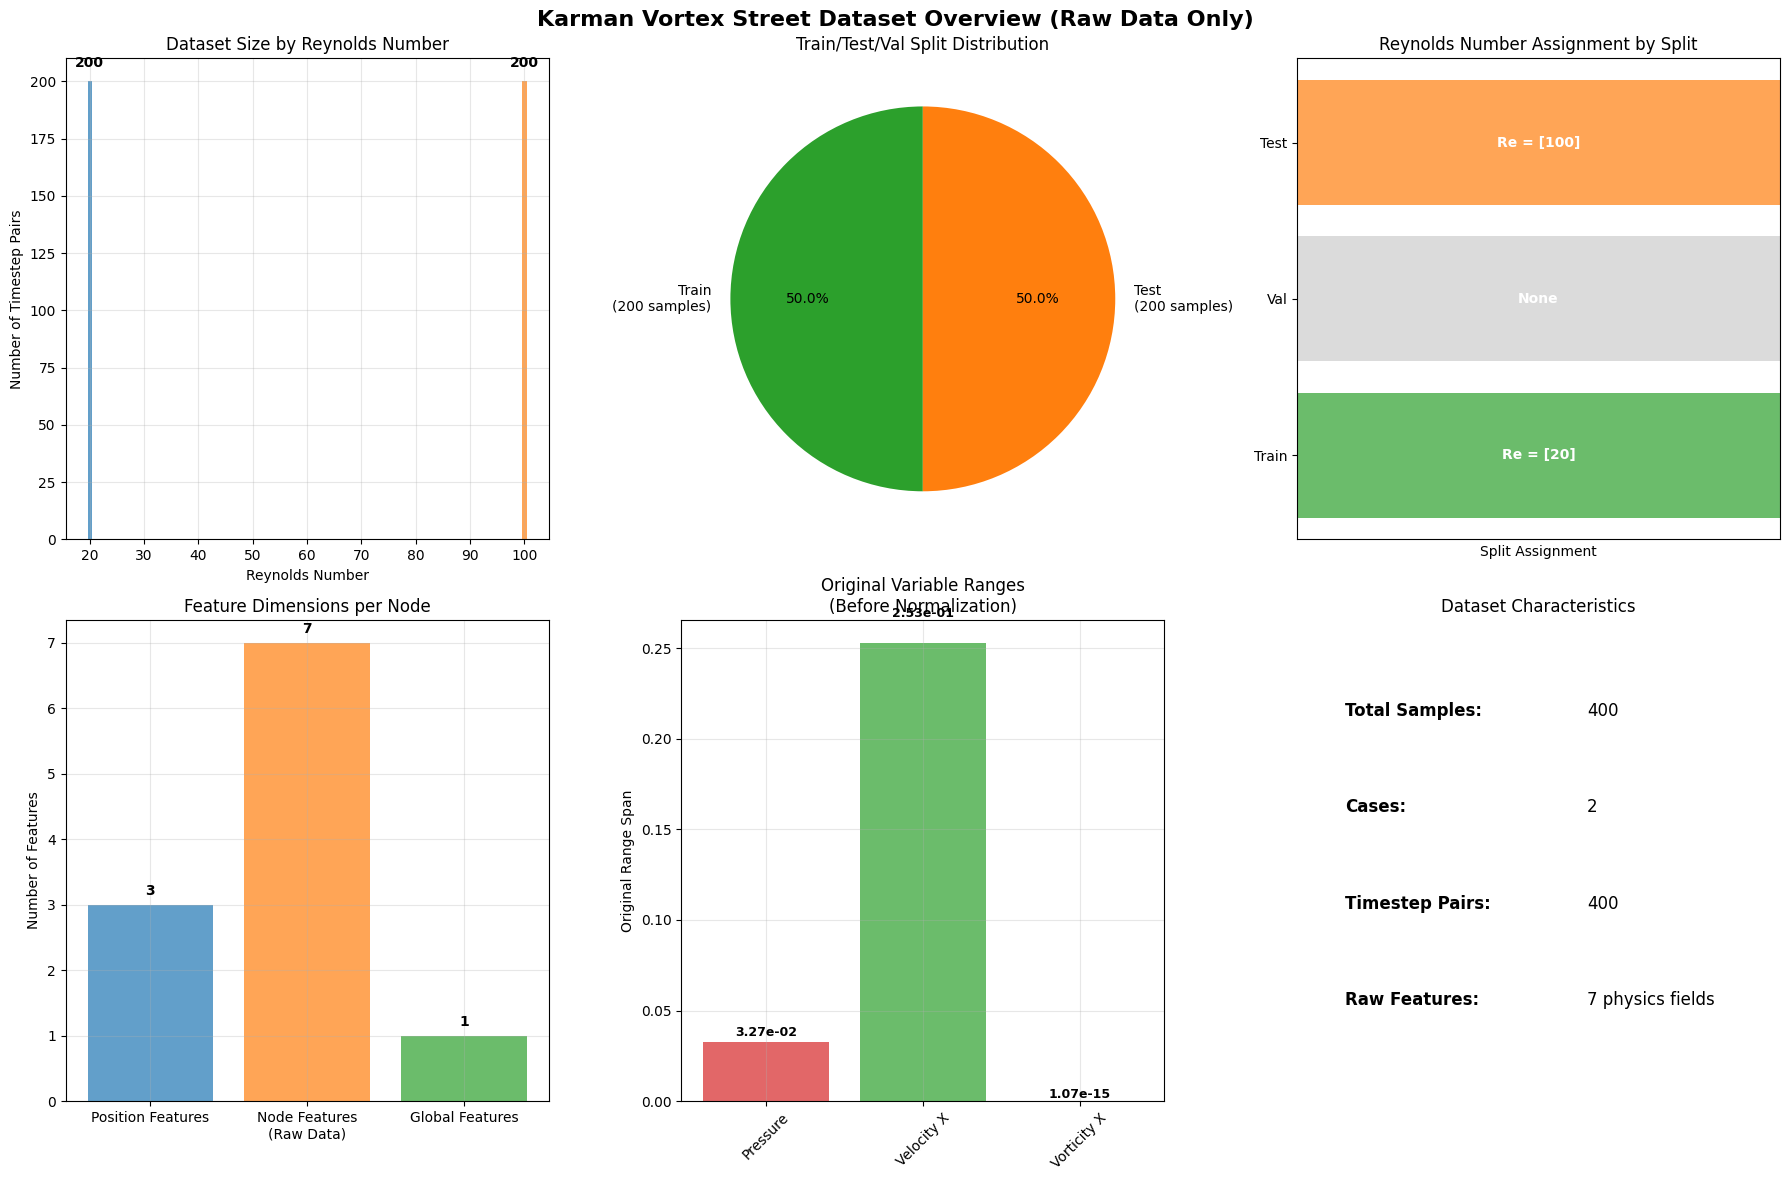


2. Normalized Feature Analysis


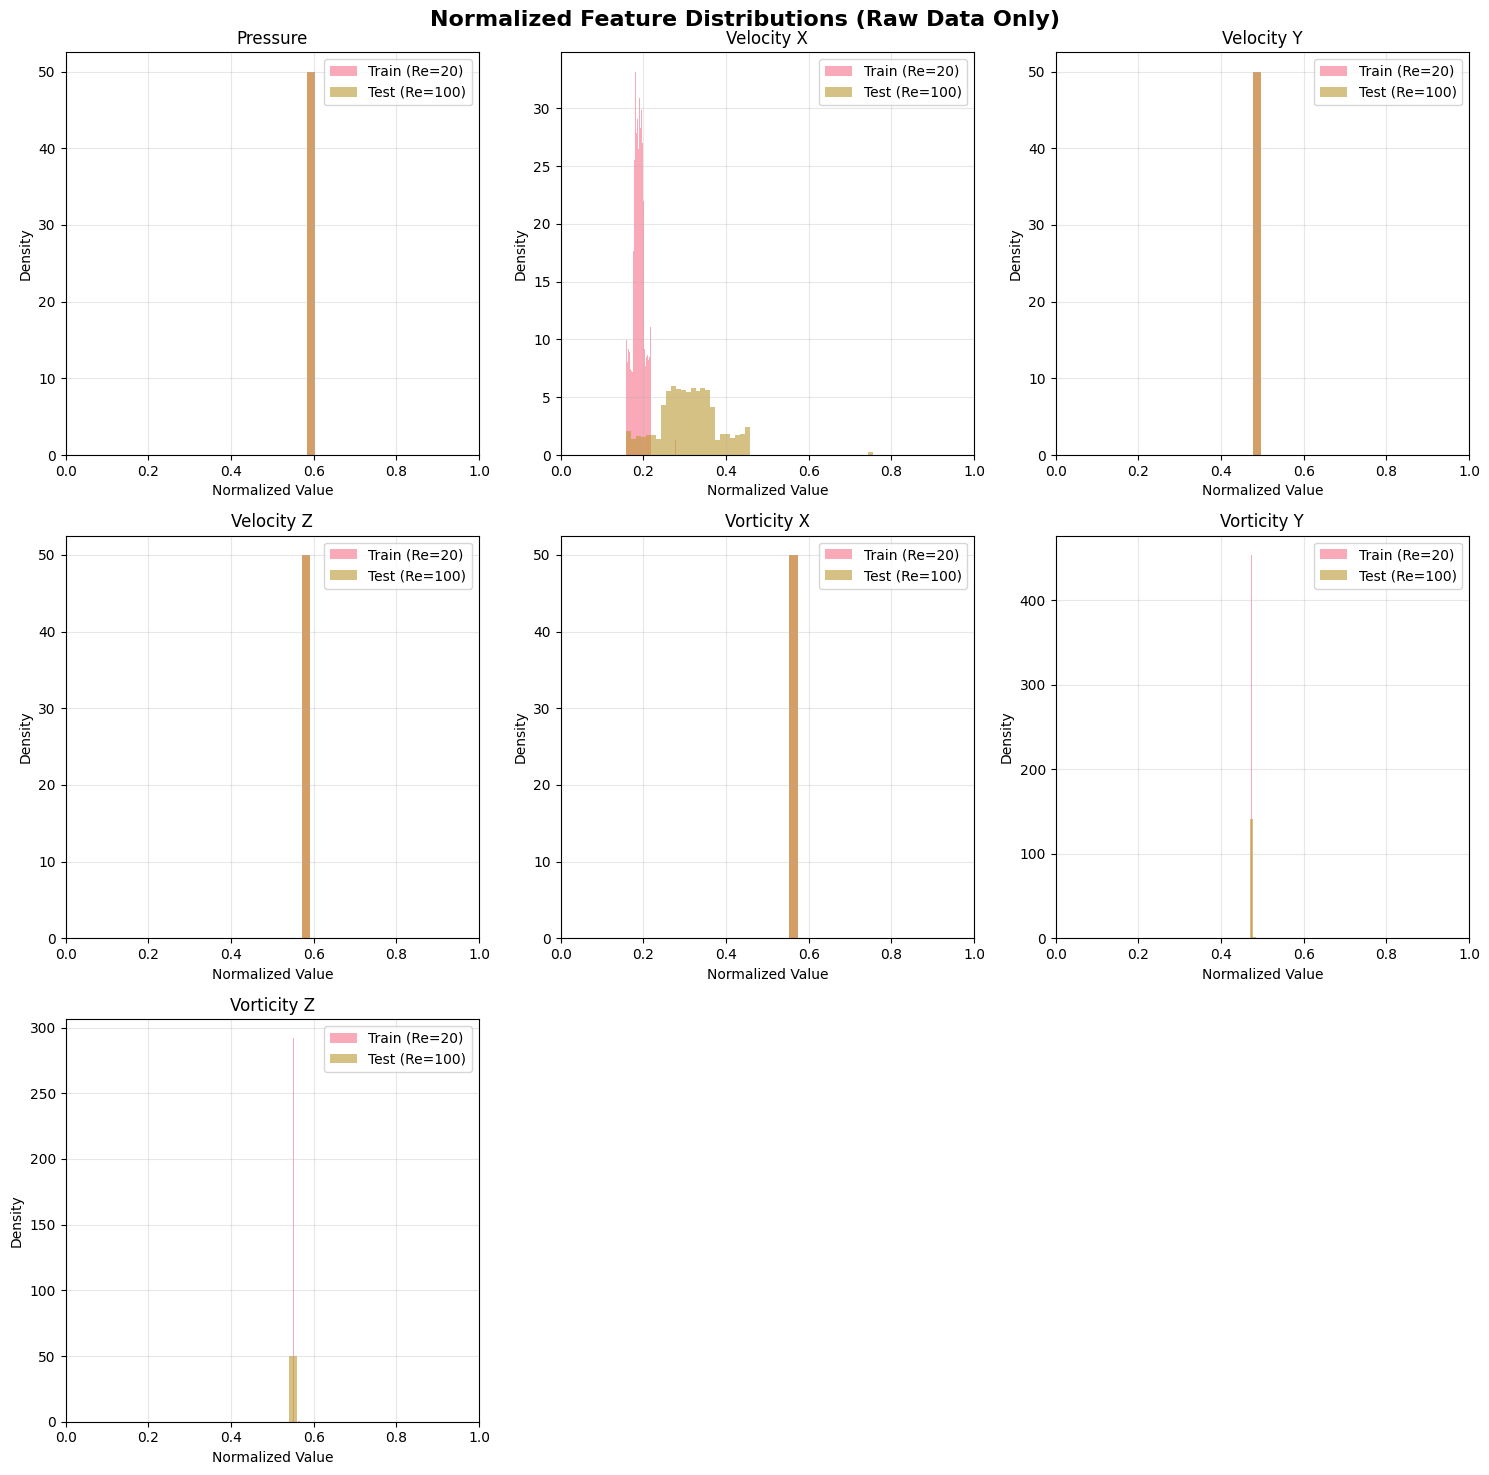


3. Parameter Normalization Analysis


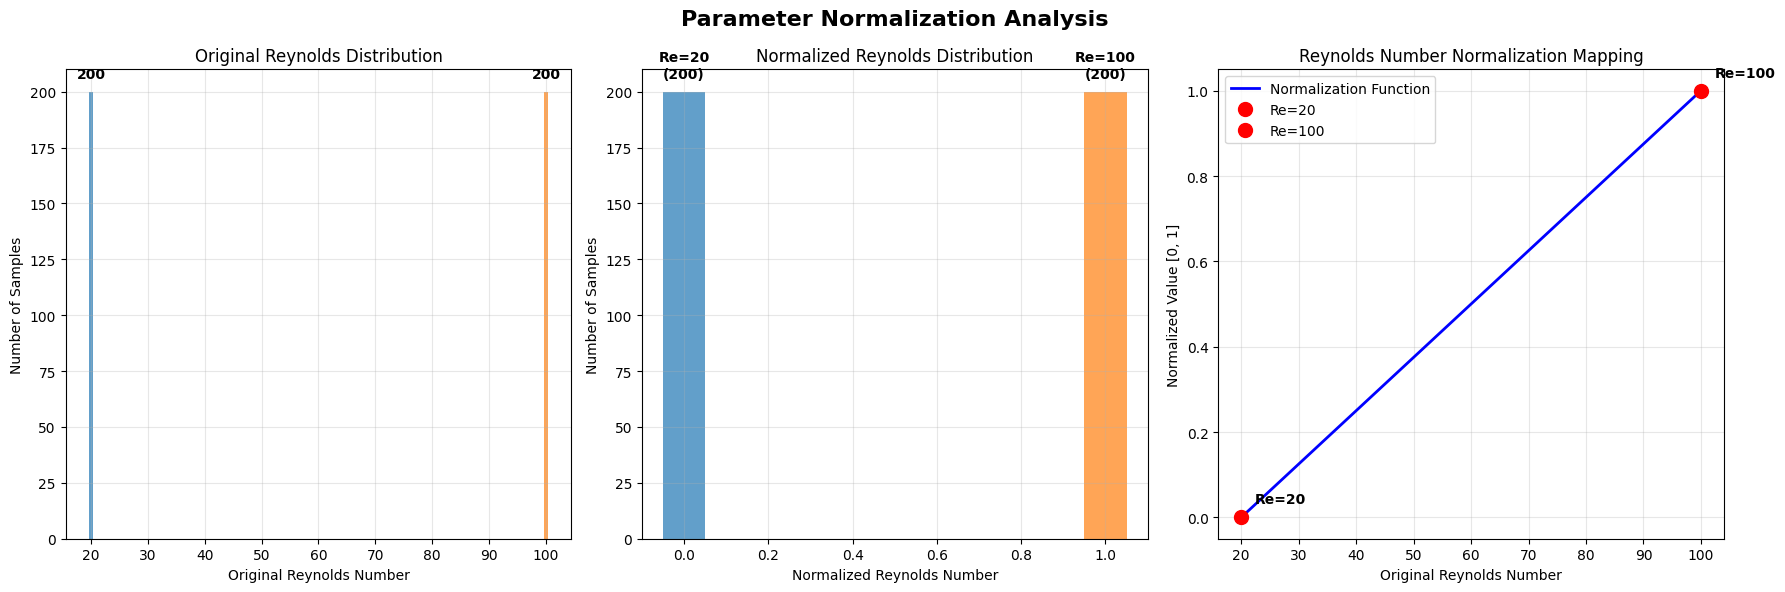


4. Individual Case Analysis
Analyzing Reynolds_20_enhanced_with_params_normalized.pt...
Analyzing Reynolds_20_raw_data_normalized.pt...
Analyzing Reynolds_100_enhanced_with_params_normalized.pt...
Analyzing Reynolds_100_raw_data_normalized.pt...


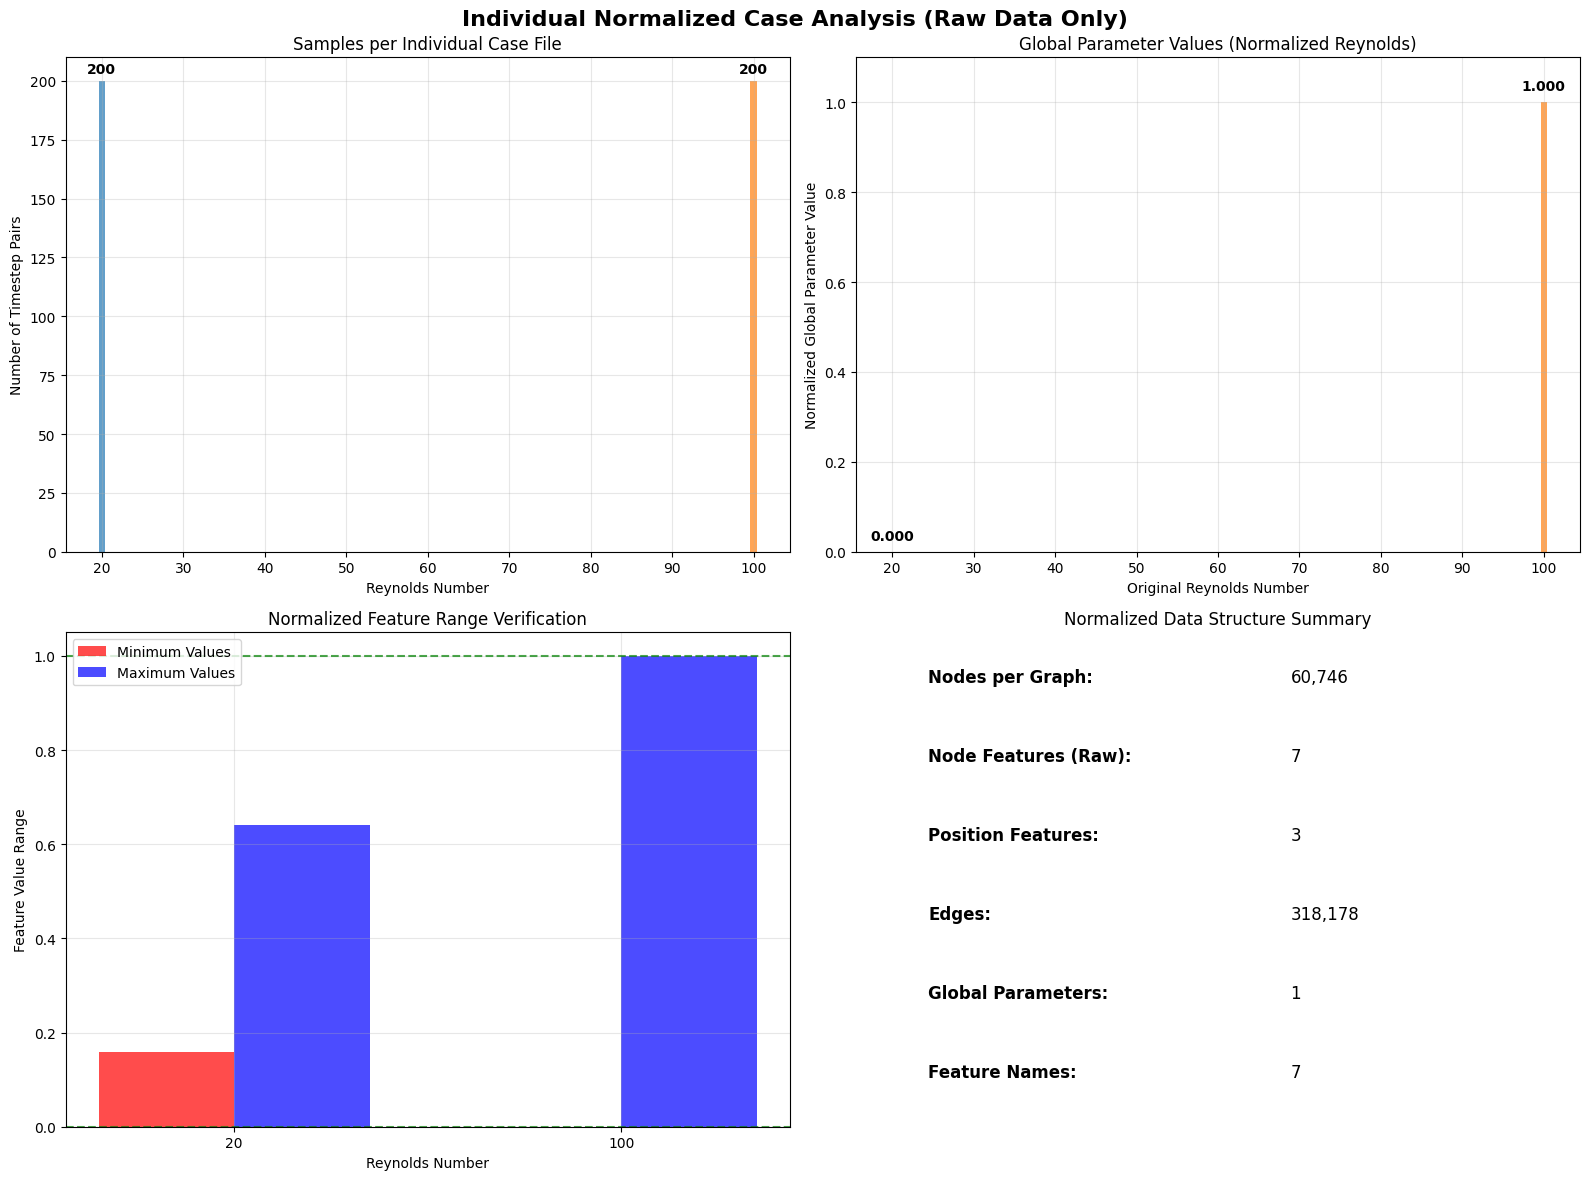


5. Graph Connectivity and Node Degree Analysis
Analyzing graph connectivity from Reynolds_20_enhanced_with_params_normalized.pt...
Graph Statistics:
  Total nodes: 60,746
  Total edges: 318,178
  Mean degree: 5.24
  Median degree: 5.0
  Std degree: 1.59
  Degree range: 3 to 21


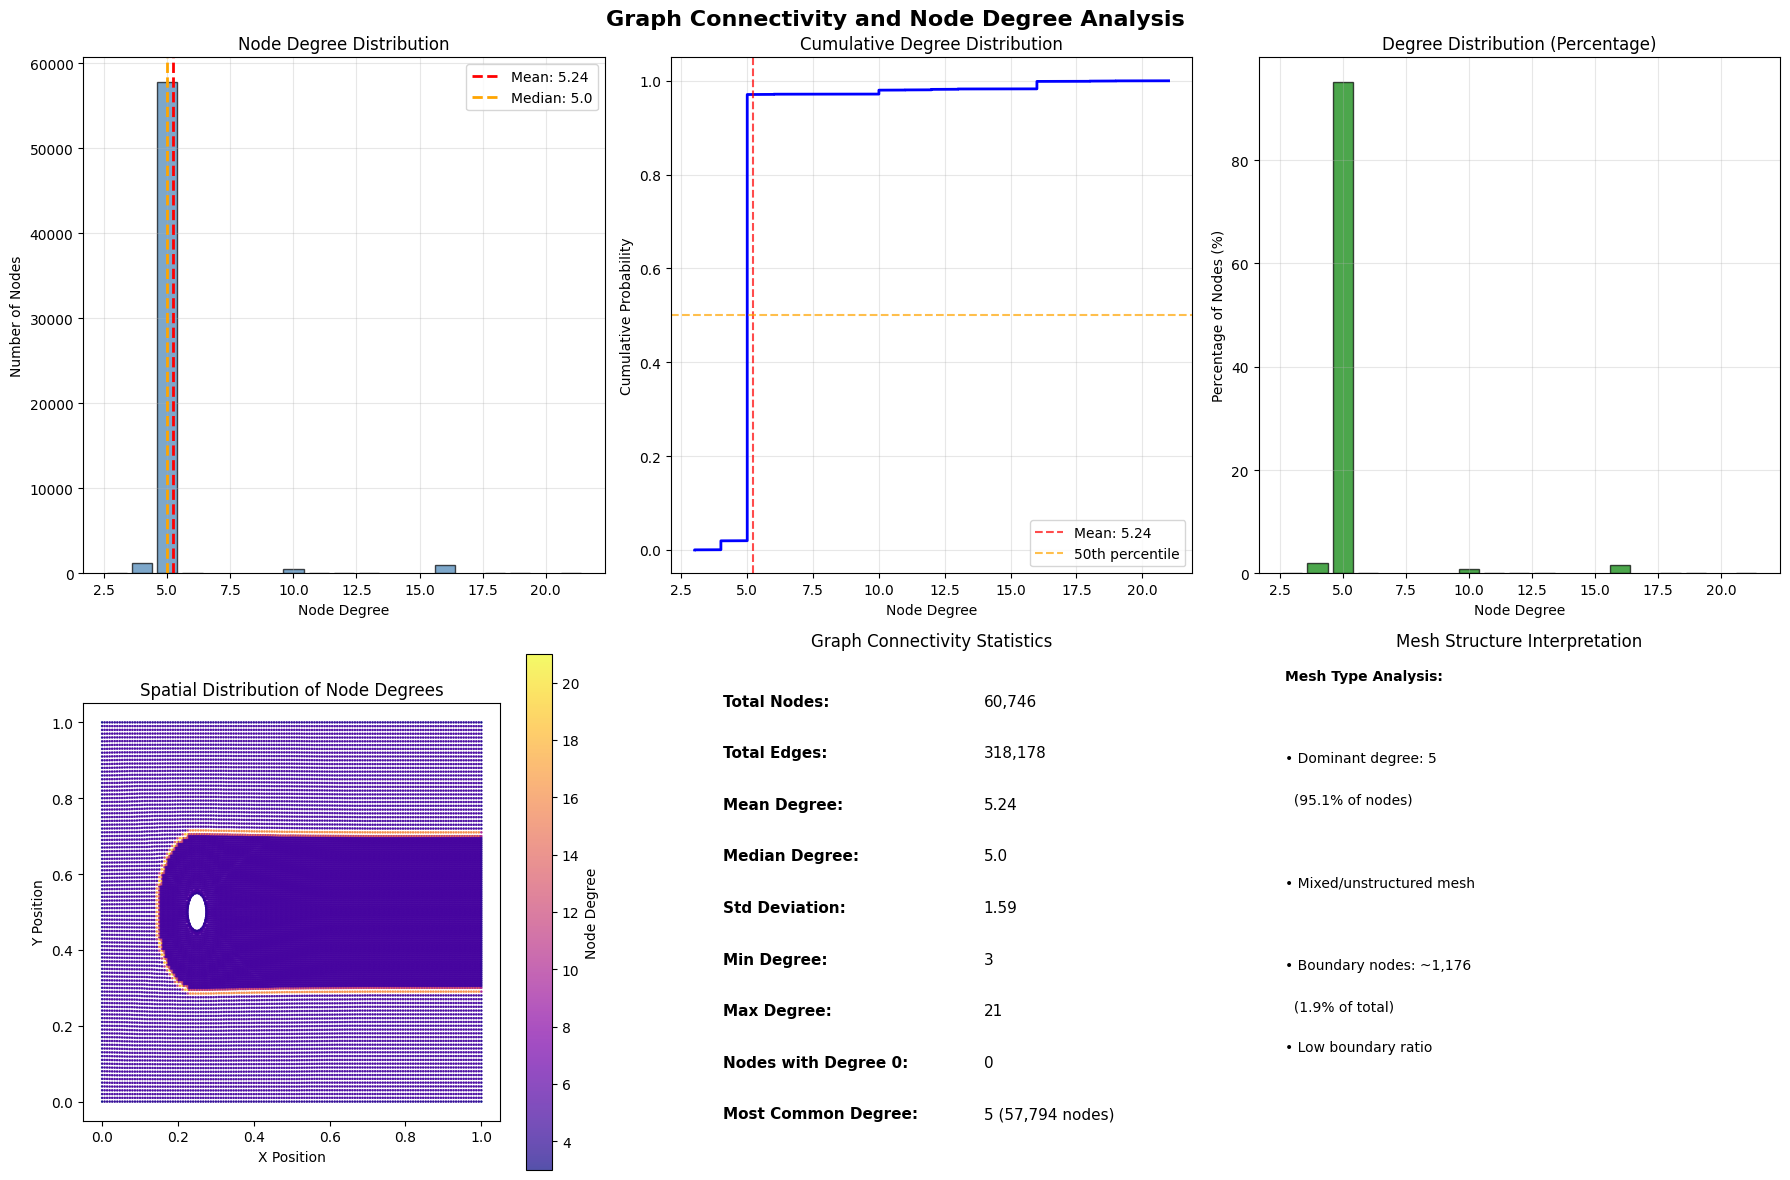


Detailed Degree Distribution:
  Degree 3: 8 nodes (0.01%)
  Degree 4: 1,168 nodes (1.92%)
  Degree 5: 57,794 nodes (95.14%)
  Degree 6: 40 nodes (0.07%)
  Degree 10: 524 nodes (0.86%)
  Degree 11: 28 nodes (0.05%)
  Degree 12: 72 nodes (0.12%)
  Degree 13: 52 nodes (0.09%)
  Degree 16: 980 nodes (1.61%)
  Degree 18: 40 nodes (0.07%)
  Degree 19: 28 nodes (0.05%)
  Degree 21: 12 nodes (0.02%)

Analysis complete!


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import re

class KarmanDatasetVisualizer:
    """
    Visualizer for analyzing the normalized Karman vortex street datasets.
    Shows parameter distributions, train/test/val splits, and data characteristics.
    Updated for RAW DATA ONLY (no derived features).
    """
    
    def __init__(self, dataset_dir):
        self.dataset_dir = Path(dataset_dir)
        self.normalized_dir = self.dataset_dir / "normalized"
        
        # Load metadata
        self.metadata = self._load_metadata()
        self.norm_metadata = self._load_normalization_metadata()
        
        # Set up plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
    def _load_metadata(self):
        """Load the main dataset metadata."""
        metadata_file = self.dataset_dir / "karman_dataset_metadata.json"
        if metadata_file.exists():
            with open(metadata_file, 'r') as f:
                return json.load(f)
        return None
    
    def _load_normalization_metadata(self):
        """Load the normalization metadata."""
        norm_metadata_file = self.normalized_dir / "normalization_metadata.json"
        if norm_metadata_file.exists():
            with open(norm_metadata_file, 'r') as f:
                return json.load(f)
        return None
    
    def visualize_dataset_overview(self):
        """Create an overview visualization of the dataset splits and parameters."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Karman Vortex Street Dataset Overview (Raw Data Only)', fontsize=16, fontweight='bold')
        
        # 1. Reynolds number distribution
        ax = axes[0, 0]
        reynolds_nums = self.metadata['reynolds_summary']['unique_values']
        case_counts = [self.metadata['case_sample_counts'][f'Reynolds_{re}'] for re in reynolds_nums]
        
        bars = ax.bar(reynolds_nums, case_counts, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
        ax.set_xlabel('Reynolds Number')
        ax.set_ylabel('Number of Timestep Pairs')
        ax.set_title('Dataset Size by Reynolds Number')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars, case_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # 2. Train/Test/Val split visualization
        ax = axes[0, 1]
        split_info = self.metadata['train_test_val_split']
        split_sizes = split_info['split_sizes']
        
        labels = ['Train', 'Val', 'Test']
        sizes = [split_sizes['train'], split_sizes['val'], split_sizes['test']]
        colors = ['#2ca02c', '#d62728', '#ff7f0e']
        
        # Only include non-zero splits
        non_zero_labels = []
        non_zero_sizes = []
        non_zero_colors = []
        for label, size, color in zip(labels, sizes, colors):
            if size > 0:
                non_zero_labels.append(f'{label}\n({size} samples)')
                non_zero_sizes.append(size)
                non_zero_colors.append(color)
        
        wedges, texts, autotexts = ax.pie(non_zero_sizes, labels=non_zero_labels, 
                                         colors=non_zero_colors, autopct='%1.1f%%',
                                         startangle=90)
        ax.set_title('Train/Test/Val Split Distribution')
        
        # 3. Reynolds assignment by split
        ax = axes[0, 2]
        reynolds_assignment = split_info['reynolds_assignment']
        
        split_reynolds = {
            'Train': reynolds_assignment['train_reynolds'],
            'Val': reynolds_assignment['val_reynolds'], 
            'Test': reynolds_assignment['test_reynolds']
        }
        
        y_pos = np.arange(len(split_reynolds))
        reynolds_text = []
        colors_list = []
        
        for split, reynolds_list in split_reynolds.items():
            if isinstance(reynolds_list, list) and len(reynolds_list) > 0:
                reynolds_text.append(f"Re = {reynolds_list}")
                if split == 'Train':
                    colors_list.append('#2ca02c')
                elif split == 'Val':
                    colors_list.append('#d62728')
                else:
                    colors_list.append('#ff7f0e')
            else:
                reynolds_text.append("None")
                colors_list.append('#cccccc')
        
        bars = ax.barh(y_pos, [1, 1, 1], color=colors_list, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(list(split_reynolds.keys()))
        ax.set_xlabel('Split Assignment')
        ax.set_title('Reynolds Number Assignment by Split')
        
        # Add Reynolds numbers as text
        for i, (bar, text) in enumerate(zip(bars, reynolds_text)):
            ax.text(0.5, bar.get_y() + bar.get_height()/2, text,
                   ha='center', va='center', fontweight='bold', color='white')
        
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        # 4. Feature dimensions breakdown
        ax = axes[1, 0]
        feature_info = self.metadata['case_info']['Reynolds_100']['feature_dimensions']
        
        dimensions = {
            'Position Features': feature_info['position_features'],
            'Node Features\n(Raw Data)': feature_info['node_features'], 
            'Global Features': feature_info['global_features']
        }
        
        dim_names = list(dimensions.keys())
        dim_values = list(dimensions.values())
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        bars = ax.bar(dim_names, dim_values, color=colors, alpha=0.7)
        ax.set_ylabel('Number of Features')
        ax.set_title('Feature Dimensions per Node')
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, dim_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{value}', ha='center', va='bottom', fontweight='bold')
        
        # 5. Variable ranges (original vs normalized) - RAW VARIABLES ONLY
        ax = axes[1, 1]
        
        # Select key raw variables to show
        key_vars = ['pressure', 'velocity_x', 'vorticity_x']
        var_ranges = []
        var_names = []
        
        for var in key_vars:
            if var in self.norm_metadata['normalization_params']:
                orig_range = self.norm_metadata['normalization_params'][var]
                var_ranges.append(orig_range['max'] - orig_range['min'])
                var_names.append(var.replace('_', ' ').title())
        
        bars = ax.bar(var_names, var_ranges, color=['#d62728', '#2ca02c', '#ff7f0e'], alpha=0.7)
        ax.set_ylabel('Original Range Span')
        ax.set_title('Original Variable Ranges\n(Before Normalization)')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Add scientific notation for values
        for bar, value in zip(bars, var_ranges):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height * 1.05,
                   f'{value:.2e}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # 6. Mesh characteristics
        ax = axes[1, 2]
        
        # Mesh info from metadata
        total_samples = self.metadata['total_samples']
        
        mesh_info = {
            'Total Samples': f"{total_samples:,}",
            'Cases': f"{self.metadata['total_cases']}",
            'Timestep Pairs': f"{total_samples:,}",
            'Raw Features': '7 physics fields'
        }
        
        # Create text display
        ax.axis('off')
        y_positions = np.linspace(0.8, 0.2, len(mesh_info))
        
        for i, (key, value) in enumerate(mesh_info.items()):
            ax.text(0.1, y_positions[i], f'{key}:', fontsize=12, fontweight='bold')
            ax.text(0.6, y_positions[i], value, fontsize=12)
        
        ax.set_title('Dataset Characteristics')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_normalized_features(self):
        """Analyze the distribution of normalized features."""
        # Load a sample from each split to analyze
        samples = {}
        
        # Load train data
        train_file = self.normalized_dir / "karman_vortex_train_normalized.pt"
        if train_file.exists():
            train_data = torch.load(train_file, weights_only=False)
            samples['train'] = train_data[0] if len(train_data) > 0 else None
        
        # Load test data  
        test_file = self.normalized_dir / "karman_vortex_test_normalized.pt"
        if test_file.exists():
            test_data = torch.load(test_file, weights_only=False)
            samples['test'] = test_data[0] if len(test_data) > 0 else None
        
        if not samples:
            print("No normalized data files found!")
            return
        
        # Create feature distribution plots
        sample_data = list(samples.values())[0]
        feature_names = sample_data.feature_names if hasattr(sample_data, 'feature_names') else [f'Feature_{i}' for i in range(sample_data.x.shape[1])]
        n_features = len(feature_names)
        
        # Create appropriate subplot grid
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        fig.suptitle('Normalized Feature Distributions (Raw Data Only)', fontsize=16, fontweight='bold')
        
        # Flatten axes for easier indexing
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes_flat = axes.flatten()
        
        # Plot each feature
        for i, feature_name in enumerate(feature_names):
            ax = axes_flat[i]
            
            # Collect feature data from all splits
            for split_name, data in samples.items():
                if data is not None:
                    feature_values = data.x[:, i].numpy()
                    
                    # Sample for performance if too many points
                    if len(feature_values) > 5000:
                        feature_values = np.random.choice(feature_values, 5000, replace=False)
                    
                    ax.hist(feature_values, bins=50, alpha=0.6, label=f'{split_name.title()} (Re={data.reynolds_number})', density=True)
            
            ax.set_xlabel('Normalized Value')
            ax.set_ylabel('Density')
            ax.set_title(f'{feature_name.replace("_", " ").title()}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 1)  # Normalized features should be in [0, 1]
        
        # Hide unused subplots
        for i in range(n_features, len(axes_flat)):
            axes_flat[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_parameter_normalization(self):
        """Visualize the parameter normalization (Reynolds numbers)."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Parameter Normalization Analysis', fontsize=16, fontweight='bold')
        
        # Original Reynolds numbers
        ax = axes[0]
        reynolds_nums = self.metadata['reynolds_summary']['unique_values']
        case_counts = [self.metadata['case_sample_counts'][f'Reynolds_{re}'] for re in reynolds_nums]
        
        bars = ax.bar(reynolds_nums, case_counts, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
        ax.set_xlabel('Original Reynolds Number')
        ax.set_ylabel('Number of Samples')
        ax.set_title('Original Reynolds Distribution')
        ax.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, case_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # Normalized Reynolds numbers
        ax = axes[1]
        if 'reynolds_number' in self.norm_metadata['global_param_normalization']:
            re_norm_params = self.norm_metadata['global_param_normalization']['reynolds_number']
            re_min = re_norm_params['min']
            re_max = re_norm_params['max']
            
            # Calculate normalized values
            normalized_reynolds = [(re - re_min) / (re_max - re_min) for re in reynolds_nums]
            
            bars = ax.bar(normalized_reynolds, case_counts, 
                         color=['#1f77b4', '#ff7f0e'], alpha=0.7, width=0.1)
            ax.set_xlabel('Normalized Reynolds Number')
            ax.set_ylabel('Number of Samples')
            ax.set_title('Normalized Reynolds Distribution')
            ax.set_xlim(-0.1, 1.1)
            ax.grid(True, alpha=0.3)
            
            # Add original values as labels
            for bar, orig_re, count in zip(bars, reynolds_nums, case_counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                       f'Re={orig_re}\n({count})', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Normalization mapping
        ax = axes[2]
        if 'reynolds_number' in self.norm_metadata['global_param_normalization']:
            re_norm_params = self.norm_metadata['global_param_normalization']['reynolds_number']
            re_min = re_norm_params['min']
            re_max = re_norm_params['max']
            
            # Create mapping line
            original_range = np.linspace(re_min, re_max, 100)
            normalized_range = (original_range - re_min) / (re_max - re_min)
            
            ax.plot(original_range, normalized_range, 'b-', linewidth=2, label='Normalization Function')
            
            # Mark actual Reynolds numbers
            for re_num in reynolds_nums:
                norm_val = (re_num - re_min) / (re_max - re_min)
                ax.plot(re_num, norm_val, 'ro', markersize=10, label=f'Re={re_num}')
                ax.annotate(f'Re={re_num}', (re_num, norm_val), 
                           xytext=(10, 10), textcoords='offset points', fontweight='bold')
            
            ax.set_xlabel('Original Reynolds Number')
            ax.set_ylabel('Normalized Value [0, 1]')
            ax.set_title('Reynolds Number Normalization Mapping')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def analyze_individual_cases(self):
        """Analyze the individual normalized case files."""
        individual_cases_dir = self.normalized_dir / "individual_cases_normalized"
        
        if not individual_cases_dir.exists():
            print("Individual normalized cases directory not found!")
            return
        
        case_files = list(individual_cases_dir.glob("*_normalized.pt"))
        
        if not case_files:
            print("No individual normalized case files found!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Individual Normalized Case Analysis (Raw Data Only)', fontsize=16, fontweight='bold')
        
        case_info = {}
        
        # Analyze each case file
        for case_file in case_files:
            print(f"Analyzing {case_file.name}...")
            
            # Extract Reynolds number from filename
            re_match = re.search(r'Reynolds_(\d+)', case_file.name)
            reynolds_num = int(re_match.group(1)) if re_match else 0
            
            # Load case data
            case_data = torch.load(case_file, weights_only=False)
            
            case_info[reynolds_num] = {
                'n_samples': len(case_data),
                'filename': case_file.name,
                'sample_data': case_data[0] if len(case_data) > 0 else None
            }
        
        # 1. Sample counts per case
        ax = axes[0, 0]
        reynolds_list = sorted(case_info.keys())
        sample_counts = [case_info[re]['n_samples'] for re in reynolds_list]
        
        bars = ax.bar(reynolds_list, sample_counts, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
        ax.set_xlabel('Reynolds Number')
        ax.set_ylabel('Number of Timestep Pairs')
        ax.set_title('Samples per Individual Case File')
        ax.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, sample_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # 2. Global parameter values (normalized Reynolds)
        ax = axes[0, 1]
        global_params = []
        
        for reynolds_num in reynolds_list:
            sample = case_info[reynolds_num]['sample_data']
            if sample and hasattr(sample, 'global_params') and sample.global_params is not None:
                global_params.append(sample.global_params[0].item())
            else:
                global_params.append(0)
        
        bars = ax.bar(reynolds_list, global_params, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
        ax.set_xlabel('Original Reynolds Number')
        ax.set_ylabel('Normalized Global Parameter Value')
        ax.set_title('Global Parameter Values (Normalized Reynolds)')
        ax.set_ylim(0, 1.1)
        ax.grid(True, alpha=0.3)
        
        for bar, param_val in zip(bars, global_params):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{param_val:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Feature range verification (should all be [0,1])
        ax = axes[1, 0]
        
        # Check if all features are properly normalized
        feature_ranges = {}
        
        for reynolds_num in reynolds_list:
            sample = case_info[reynolds_num]['sample_data']
            if sample:
                # Check feature ranges
                x_min = sample.x.min().item()
                x_max = sample.x.max().item()
                feature_ranges[reynolds_num] = {'min': x_min, 'max': x_max}
        
        reynolds_nums = list(feature_ranges.keys())
        mins = [feature_ranges[re]['min'] for re in reynolds_nums]
        maxs = [feature_ranges[re]['max'] for re in reynolds_nums]
        
        x_pos = np.arange(len(reynolds_nums))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, mins, width, label='Minimum Values', alpha=0.7, color='red')
        bars2 = ax.bar(x_pos + width/2, maxs, width, label='Maximum Values', alpha=0.7, color='blue')
        
        ax.set_xlabel('Reynolds Number')
        ax.set_ylabel('Feature Value Range')
        ax.set_title('Normalized Feature Range Verification')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(reynolds_nums)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Expected Min (0)')
        ax.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Expected Max (1)')
        
        # 4. Data structure summary
        ax = axes[1, 1]
        ax.axis('off')
        
        # Create summary table
        sample = case_info[reynolds_list[0]]['sample_data']
        if sample:
            summary_info = {
                'Nodes per Graph': f"{sample.pos.shape[0]:,}",
                'Node Features (Raw)': f"{sample.x.shape[1]}",
                'Position Features': f"{sample.pos.shape[1]}",
                'Edges': f"{sample.edge_index.shape[1]:,}",
                'Global Parameters': f"{sample.global_params.shape[0] if sample.global_params is not None else 0}",
                'Feature Names': f"{len(sample.feature_names) if hasattr(sample, 'feature_names') else 'N/A'}"
            }
            
            y_positions = np.linspace(0.9, 0.1, len(summary_info))
            
            for i, (key, value) in enumerate(summary_info.items()):
                ax.text(0.1, y_positions[i], f'{key}:', fontsize=12, fontweight='bold')
                ax.text(0.6, y_positions[i], value, fontsize=12)
        
        ax.set_title('Normalized Data Structure Summary')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_graph_connectivity(self):
        """Analyze the graph connectivity and node degree distribution."""
        # Load a sample to analyze graph structure
        individual_cases_dir = self.normalized_dir / "individual_cases_normalized"
        
        if not individual_cases_dir.exists():
            print("Individual normalized cases directory not found!")
            return
        
        case_files = list(individual_cases_dir.glob("*_normalized.pt"))
        
        if not case_files:
            print("No individual normalized case files found!")
            return
        
        # Load first case for graph analysis
        sample_case = torch.load(case_files[0], weights_only=False)
        sample_data = sample_case[0] if len(sample_case) > 0 else None
        
        if sample_data is None or not hasattr(sample_data, 'edge_index'):
            print("No graph connectivity data found!")
            return
        
        print(f"Analyzing graph connectivity from {case_files[0].name}...")
        
        # Extract graph properties
        edge_index = sample_data.edge_index
        num_nodes = sample_data.pos.shape[0]
        num_edges = edge_index.shape[1]
        
        # Calculate node degrees
        from collections import Counter
        
        # Count outgoing edges for each node
        source_nodes = edge_index[0].numpy()
        degrees = Counter(source_nodes)
        
        # Create degree array for all nodes (some might have degree 0)
        degree_array = np.zeros(num_nodes, dtype=int)
        for node_id, degree in degrees.items():
            degree_array[node_id] = degree
        
        # Calculate statistics
        mean_degree = np.mean(degree_array)
        median_degree = np.median(degree_array)
        max_degree = np.max(degree_array)
        min_degree = np.min(degree_array)
        std_degree = np.std(degree_array)
        
        # Count nodes by degree
        degree_counts = Counter(degree_array)
        
        print(f"Graph Statistics:")
        print(f"  Total nodes: {num_nodes:,}")
        print(f"  Total edges: {num_edges:,}")
        print(f"  Mean degree: {mean_degree:.2f}")
        print(f"  Median degree: {median_degree}")
        print(f"  Std degree: {std_degree:.2f}")
        print(f"  Degree range: {min_degree} to {max_degree}")
        
        # Create visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Graph Connectivity and Node Degree Analysis', fontsize=16, fontweight='bold')
        
        # 1. Degree histogram
        ax = axes[0, 0]
        degrees_list = list(degree_counts.keys())
        counts_list = list(degree_counts.values())
        
        bars = ax.bar(degrees_list, counts_list, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_xlabel('Node Degree')
        ax.set_ylabel('Number of Nodes')
        ax.set_title('Node Degree Distribution')
        ax.grid(True, alpha=0.3)
        
        # Add mean and median lines
        ax.axvline(mean_degree, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_degree:.2f}')
        ax.axvline(median_degree, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_degree}')
        ax.legend()
        
        # 2. Cumulative degree distribution
        ax = axes[0, 1]
        sorted_degrees = np.sort(degree_array)
        cumulative_prob = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
        
        ax.plot(sorted_degrees, cumulative_prob, 'b-', linewidth=2)
        ax.set_xlabel('Node Degree')
        ax.set_ylabel('Cumulative Probability')
        ax.set_title('Cumulative Degree Distribution')
        ax.grid(True, alpha=0.3)
        ax.axvline(mean_degree, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_degree:.2f}')
        ax.axhline(0.5, color='orange', linestyle='--', alpha=0.7, label='50th percentile')
        ax.legend()
        
        # 3. Log-scale degree distribution (if wide range)
        ax = axes[0, 2]
        if max_degree > min_degree * 10:  # Only if there's a wide range
            log_counts = [np.log10(count) for count in counts_list]
            bars = ax.bar(degrees_list, log_counts, alpha=0.7, color='green', edgecolor='black')
            ax.set_xlabel('Node Degree')
            ax.set_ylabel('log₁₀(Number of Nodes)')
            ax.set_title('Log-Scale Degree Distribution')
        else:
            # Show degree percentage instead
            percentages = [(count / num_nodes) * 100 for count in counts_list]
            bars = ax.bar(degrees_list, percentages, alpha=0.7, color='green', edgecolor='black')
            ax.set_xlabel('Node Degree')
            ax.set_ylabel('Percentage of Nodes (%)')
            ax.set_title('Degree Distribution (Percentage)')
        ax.grid(True, alpha=0.3)
        
        # 4. Spatial degree distribution
        ax = axes[1, 0]
        pos_2d = sample_data.pos[:, :2].numpy()  # Use x-y coordinates
        
        # Create scatter plot colored by degree
        scatter = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=degree_array, 
                           cmap='plasma', s=0.5, alpha=0.7)
        plt.colorbar(scatter, ax=ax, label='Node Degree')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title('Spatial Distribution of Node Degrees')
        ax.set_aspect('equal')
        
        # 5. Degree statistics summary
        ax = axes[1, 1]
        ax.axis('off')
        
        # Create statistics table
        stats_info = {
            'Total Nodes': f"{num_nodes:,}",
            'Total Edges': f"{num_edges:,}",
            'Mean Degree': f"{mean_degree:.2f}",
            'Median Degree': f"{median_degree}",
            'Std Deviation': f"{std_degree:.2f}",
            'Min Degree': f"{min_degree}",
            'Max Degree': f"{max_degree}",
            'Nodes with Degree 0': f"{np.sum(degree_array == 0):,}",
            'Most Common Degree': f"{max(degree_counts, key=degree_counts.get)} ({max(degree_counts.values()):,} nodes)"
        }
        
        y_positions = np.linspace(0.9, 0.1, len(stats_info))
        
        for i, (key, value) in enumerate(stats_info.items()):
            ax.text(0.1, y_positions[i], f'{key}:', fontsize=11, fontweight='bold')
            ax.text(0.6, y_positions[i], value, fontsize=11)
        
        ax.set_title('Graph Connectivity Statistics')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        # 6. Mesh interpretation
        ax = axes[1, 2]
        ax.axis('off')
        
        # Interpret the mesh structure based on degree distribution
        most_common_degree = max(degree_counts, key=degree_counts.get)
        most_common_percentage = (degree_counts[most_common_degree] / num_nodes) * 100
        
        interpretation = []
        interpretation.append(f"Mesh Type Analysis:")
        interpretation.append(f"")
        interpretation.append(f"• Dominant degree: {most_common_degree}")
        interpretation.append(f"  ({most_common_percentage:.1f}% of nodes)")
        interpretation.append(f"")
        
        if most_common_degree == 4:
            interpretation.append("• Likely: 2D quadrilateral mesh")
        elif most_common_degree == 6:
            interpretation.append("• Likely: 2D triangular mesh")
        elif most_common_degree == 8:
            interpretation.append("• Likely: 2D structured grid")
        elif most_common_degree in [12, 16, 20]:
            interpretation.append("• Likely: 3D hexahedral mesh")
        else:
            interpretation.append("• Mixed/unstructured mesh")
        
        interpretation.append(f"")
        boundary_nodes = np.sum(degree_array < most_common_degree)
        boundary_percentage = (boundary_nodes / num_nodes) * 100
        interpretation.append(f"• Boundary nodes: ~{boundary_nodes:,}")
        interpretation.append(f"  ({boundary_percentage:.1f}% of total)")
        
        if boundary_percentage > 20:
            interpretation.append("• High boundary ratio")
        elif boundary_percentage < 5:
            interpretation.append("• Low boundary ratio")
        else:
            interpretation.append("• Typical boundary ratio")
        
        # Display interpretation
        for i, line in enumerate(interpretation):
            ax.text(0.05, 0.95 - i*0.08, line, fontsize=10, 
                   fontweight='bold' if line.endswith(':') else 'normal',
                   transform=ax.transAxes)
        
        ax.set_title('Mesh Structure Interpretation')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed degree distribution
        print(f"\nDetailed Degree Distribution:")
        sorted_degrees = sorted(degree_counts.items())
        for degree, count in sorted_degrees[:15]:  # Show first 15 degree values
            percentage = (count / num_nodes) * 100
            print(f"  Degree {degree}: {count:,} nodes ({percentage:.2f}%)")
        
        if len(sorted_degrees) > 15:
            print(f"  ... and {len(sorted_degrees) - 15} more degree values")
        
    def create_complete_analysis(self):
        """Create a complete analysis of the dataset."""
        print("Creating complete Karman vortex dataset analysis...")
        
        print("\n1. Dataset Overview")
        self.visualize_dataset_overview()
        
        print("\n2. Normalized Feature Analysis")
        self.analyze_normalized_features()
        
        print("\n3. Parameter Normalization Analysis")
        self.visualize_parameter_normalization()
        
        print("\n4. Individual Case Analysis")
        self.analyze_individual_cases()
        
        print("\n5. Graph Connectivity and Node Degree Analysis")
        self.analyze_graph_connectivity()
        
        print("\nAnalysis complete!")


# Usage function
def analyze_karman_dataset(dataset_dir):
    """
    Convenience function to analyze a Karman vortex dataset.
    
    Parameters:
    -----------
    dataset_dir : str
        Path to the dataset directory containing metadata and normalized data
    """
    visualizer = KarmanDatasetVisualizer(dataset_dir)
    visualizer.create_complete_analysis()
    return visualizer


if __name__ == "__main__":
    # Example usage
    dataset_path = "/project/vil_baek/psaap/cylinder"
    
    print("Karman Vortex Street Dataset Visualizer")
    print(f"Analyzing dataset at: {dataset_path}")
    
    visualizer = analyze_karman_dataset(dataset_path)